In [5]:
%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import pandas as pd
import numpy as np
from PIL import Image
from math import floor
import matplotlib.pyplot as plt
import datetime
from UAVSequence import UAVSequence, ImageSequence
from ValidationCallback import ValidationCallback
from VAEModel import Sampling, VAE
import math
import PyKDL
# Clear logs from previous runs
# %rm -rf ../logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
NUM_INPUTS = 10
NUM_OUTPUTS = 11

img_shape = (480, 640)

# Load the dataset input and output
x = np.loadtxt('../dataset_empty_auto/0_input.csv', delimiter=',', usecols=tuple(range(NUM_INPUTS))) # (num training points, 13)
y = np.loadtxt('../dataset_empty_auto/0_output.csv', delimiter=',', usecols=tuple(range(NUM_OUTPUTS + 4))) # (num training points, 11)

def get_rel_yaw(cur, goal):
    diff = goal - cur
    
    if diff > math.pi:
        diff -= 2 * math.pi
    elif diff < -1 * math.pi:
        diff += 2 * math.pi
    
    return diff

for i in range(len(y)):
    f = PyKDL.Frame(PyKDL.Rotation.RPY(*x[i][3:6]),
                    PyKDL.Vector(*x[i][0:3]))

    # INPUTS
    lin_vel = f * PyKDL.Vector(*x[i][8:11])
    ang_vel = f * PyKDL.Vector(*x[i][11:14])    
    x[i][8:11] = lin_vel[0:3]
    x[i][11:14] = ang_vel[0:3]
    
    vector_f = PyKDL.Frame(PyKDL.Rotation.RPY(*x[i][3:6]),
                    PyKDL.Vector(0, 0, 0))
    
    # OUTPUTS
    pos = f * PyKDL.Vector(*y[i][0:3])
    vel = vector_f * PyKDL.Vector(*y[i][3:6])
    acc = vector_f * PyKDL.Vector(*y[i][6:9])
    y[i][0:3] = pos[0:3]
    y[i][3:6] = vel[0:3]
    y[i][6:9] = acc[0:3]
    
    y[i][9] = get_rel_yaw(x[i][5], y[i][9])
    
    
x = np.delete(x, np.s_[5], 1)
x = np.delete(x, np.s_[0:3], 1)

num_training_samples = int(0.8 * len(x))
num_val_samples = len(x) - num_training_samples

x_val = x[num_training_samples:]
y_val = y[num_training_samples:]
x = x[:num_training_samples]
y = y[:num_training_samples]

# Shuffle x and y, but store the indices so we can still match them with the images
hash_table = np.random.permutation(num_training_samples)
hash_table_val = np.random.permutation(num_val_samples)

x = x[hash_table]
y = y[hash_table]
x_val = x_val[hash_table_val]
y_val = y_val[hash_table_val]

Next comes actually training on the data. 
PS. If you want to view the tensorboard data, run `tensorboard --logdir logs/fit` in another window.

In [8]:
latent_dim = 1000

encoder_inputs = Input(shape=(*img_shape, 1), name="encoder_input")
a = Conv2D(32, 7, strides=4, padding="same", activation="relu")(encoder_inputs)
a = Conv2D(32, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2D(64, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2D(64, 5, strides=5, padding="same", activation="relu")(a)
a = Flatten()(a)
z_mean = Dense(latent_dim, name="z_mean")(a)
z_log_var = Dense(latent_dim, name="z_log_var")(a)
z = Sampling()([z_mean, z_log_var])
# encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder = Model(encoder_inputs, z_mean, name="encoder")
# encoder.summary()

# latent_inputs = Input(shape=(latent_dim,))
a = Dense(6 * 8 * 64, activation="relu")(z)
a = Reshape((6, 8, 64))(a)
a = Conv2DTranspose(64, 5, strides=5, padding="same", activation="relu")(a)
a = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(a)
decoder_outputs = Conv2DTranspose(1, 7, strides=4, padding="same", activation="relu")(a)
# decoder = Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

vae = Model(encoder_inputs, decoder_outputs)
vae.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 160, 32) 1600        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 80, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 40, 64)   18496       conv2d_1[0

In [9]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
xy = ImageSequence(x, BATCH_SIZE, img_shape, hash_table)
xy_validation = ImageSequence(x_val, BATCH_SIZE, img_shape, hash_table_val, num_training_samples)

batch is 32
batch is 32


In [10]:
def vae_loss(input_img, reconstructed_img):
    reconstruction_loss = tf.keras.losses.MSE(input_img, reconstructed_img)
    reconstruction_loss *= 480 * 640
    
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    total_loss = reconstruction_loss + kl_loss
    return total_loss

In [6]:
NUM_EPOCHS = 30
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(xy, epochs=NUM_EPOCHS, callbacks=[ValidationCallback(xy_validation)])

Epoch 1/30
   1/1347 [..............................] - ETA: 37:32 - loss: 1.4653

KeyboardInterrupt: 

In [ ]:
plt.imshow(xy[5][0][0])

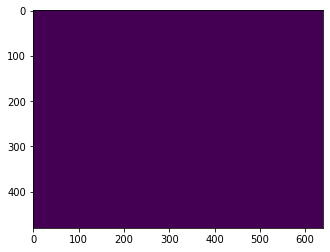

In [9]:
prediction = vae.predict(xy[5][0])[0]
plt.imshow(prediction)

In [10]:
# Save the model
vae.save('../models/vae_empty.tf')
encoder.save('../models/encoder_empty.tf')

In [11]:
# Load the model
loaded_model_vae = tf.keras.models.load_model('../models/vae_empty.tf', custom_objects={"Sampling": Sampling, "vae_loss": vae_loss})
loaded_model_encoder = tf.keras.models.load_model('../models/encoder_empty.tf')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# 1. Get the latent space representation of the image from the encoder
NUM_INPUTS = 10
NUM_OUTPUTS = 11
img_shape = (480, 640)

image_inputs = Input(shape=(*img_shape, 1))
numerical_inputs = Input(shape=(NUM_INPUTS,))

loaded_model_encoder.trainable = False
z_mean = loaded_model_encoder(image_inputs)
z_mean = Flatten()(z_mean)
combined = concatenate([z_mean, numerical_inputs])

# BEST: 500/250/100/50/25/11   |     0.342
#       300/100/33             |     0.541
#       500/250/100/50/25/11   |     0.991     |     0.001 l2 regularization

# x_combined = Dropout(0.5)(combined)
x_combined = Dense(500, kernel_regularizer=l2(0.00), activation='relu')(combined)
x_combined = Dense(250, kernel_regularizer=l2(0.00), activation='relu')(x_combined)
x_combined = Dense(100, kernel_regularizer=l2(0.00), activation='relu')(x_combined)
x_combined = Dense(50, kernel_regularizer=l2(0.00), activation='relu')(x_combined)
x_combined = Dense(25, kernel_regularizer=l2(0.00), activation='relu')(x_combined)
# x_combined = Dropout(0.3)(x_combined)
# x_combined = Dense(30, kernel_regularizer=l2(0.00), activation='relu')(x_combined)
outputs = Dense(NUM_OUTPUTS, kernel_regularizer=l2(0.00), activation='linear')(x_combined)

model = Model([image_inputs, numerical_inputs], outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 1000)         3204808     input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1000)         0           encoder[1][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
____________________________________________________________________________________________

In [13]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
xy = UAVSequence(x, y, BATCH_SIZE, img_shape, hash_table)
xy_validation = UAVSequence(x_val, y_val, BATCH_SIZE, img_shape, hash_table_val, num_training_samples)

batch is 32
batch is 32


In [14]:
def model_loss(target, predicted):
    other_loss = tf.keras.losses.MSE(target[:,:9], predicted[:,:9])
    yaw_loss = 10 * tf.keras.losses.MSE(target[:,9:], predicted[:,9:])
    
    total_loss = (other_loss * 9 + yaw_loss * 2) / 11
    return total_loss

In [15]:
def pos_metric(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:,:3], y_pred[:,:3])

def vel_metric(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:,3:6], y_pred[:,3:6])

def acc_metric(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:,6:9], y_pred[:,6:9])

def yaw_metric(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:,9:], y_pred[:,9:])

In [ ]:
NUM_EPOCHS = 100
model.compile(optimizer='adam', loss=tf.keras.losses.MSE, metrics=[pos_metric, vel_metric, acc_metric, yaw_metric])
model.fit(xy, epochs=NUM_EPOCHS, callbacks=[ValidationCallback(xy_validation)])

Epoch 1/100
1347/1347 [==============================] - 110s 82ms/step - loss: 0.0752 - pos_metric: 0.0874 - vel_metric: 0.0217 - acc_metric: 0.1184 - yaw_metric: 0.0725
Epoch 2/100
1347/1347 [==============================] - 110s 82ms/step - loss: 0.0343 - pos_metric: 0.0588 - vel_metric: 0.0057 - acc_metric: 0.0304 - yaw_metric: 0.0462
Epoch 3/100
1347/1347 [==============================] - 110s 81ms/step - loss: 0.0288 - pos_metric: 0.0516 - vel_metric: 0.0051 - acc_metric: 0.0236 - yaw_metric: 0.0376
Epoch 4/100
1347/1347 [==============================] - 110s 81ms/step - loss: 0.0263 - pos_metric: 0.0473 - vel_metric: 0.0048 - acc_metric: 0.0208 - yaw_metric: 0.0352
Epoch 5/100
1347/1347 [==============================] - 109s 81ms/step - loss: 0.0238 - pos_metric: 0.0428 - vel_metric: 0.0046 - acc_metric: 0.0188 - yaw_metric: 0.0317
Epoch 6/100
1347/1347 [==============================] - 108s 80ms/step - loss: 0.0215 - pos_metric: 0.0390 - vel_metric: 0.0043 - acc_metric: 0.

In [13]:
# Save the model
model.save('../models/complete_empty_30_min_rel_pos_0_030.tf')

In [17]:
loaded_model_complete = tf.keras.models.load_model('../models/complete_empty_30_min_rel_pos_0_030.tf', custom_objects={"pos_metric": pos_metric, "vel_metric": vel_metric, "acc_metric": acc_metric, "yaw_metric": yaw_metric})

In [23]:
BATCH = 1
NUM = 0
print(xy_validation[BATCH][1][NUM])
single_x_test = xy_validation[BATCH][0]
single_x_test[0] = single_x_test[0][NUM]
single_x_test[1] = single_x_test[1][NUM]
# print(single_x_test[0].shape)
# print(single_x_test[1].shape)
single_x_test[0] = np.array([single_x_test[0],])
single_x_test[1] = np.array([single_x_test[1],])
# print(single_x_test[1])
# print(single_x_test[0].shape)
# print(single_x_test[1].shape)

prediction = loaded_model_complete.predict(single_x_test)[0]
print(prediction)

print(np.asarray(xy_validation[BATCH][1][NUM]) - np.asarray(prediction))

[ 1.126400e-01  6.292000e-02  3.170000e-03  1.825582e+00 -4.321980e-01
 -3.900000e-05  5.626340e-01  6.688060e-01  7.000000e-06 -1.975620e-01
 -2.372890e-01]
[ 0.13429113  0.05333463 -0.0191496   1.7202779  -0.5699907   0.04652605
  0.47043067  0.65620583 -0.01152456 -0.26060554 -0.04743019]
[-0.02165113  0.00958537  0.0223196   0.10530409  0.13779269 -0.04656505
  0.09220333  0.01260017  0.01153156  0.06304354 -0.18985881]
